# **Lab:Logistic Regression, LDA, QDA and KNN**

## **The Stock Market Data**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')

style.use('fivethirtyeight')

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import statsmodels.api as sm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('/content/drive/My Drive/Repos/Git/Machine-Learning/An Introduction to Statistical Learning/Dataset/Smarket.csv')

In [3]:
data.isnull().any()

Unnamed: 0    False
Year          False
Lag1          False
Lag2          False
Lag3          False
Lag4          False
Lag5          False
Volume        False
Today         False
Direction     False
dtype: bool

In [4]:
data.drop('Unnamed: 0',1,inplace=True)

In [5]:
data.head(3)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down


**Dataset info:**
 
 This data set consists of percentage returns for S&P 500 stock index over 
 1,250 days, from beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume`(No.of Shares traded the previous day, in billions), `Today`(the percentage return on the date in question) and `Direction` (Whether the Market was Up or Down on this date.)

In [6]:
data.describe() # Gives a Statistical Description of all the Numerical Features 

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [7]:
data.corr()
# Correlation Function produces a Correlation Matrix between Numerical Features.

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


---
**Observation:**
- The Correlation between the Lag variables and Today's return's are close to zero.
- The only substantial correlation is between Year and Volume.
- In other words, the Volume of shares traded increased from the year 2001 to 2005.

---

### **Applying Logistic Regression**

Now, we will fit a logistic regression model in order to predict the Direction using Lag1 through Lag5 and Volume. The `GLM()` function fits *generalized linear model*, a class of models that includes logistic regression. We must pass the argument `family = binomial` in order to run a logistic regression rather than some type of generalized linear model.

#### **Using Statsmodels**

In [8]:
data['Direction_Encoded'] = pd.get_dummies(data.Direction,drop_first=True)

In [9]:
X = data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']] # Exogenos Variables
y = data['Direction_Encoded'] # Response Variable

In [10]:
X = sm.add_constant(X) # Adding Constant for intercept value

In [11]:
sm_model = sm.GLM(y,X,family=sm.families.Binomial()).fit()
print(sm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      Direction_Encoded   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Thu, 25 Jun 2020   Deviance:                       1727.6
Time:                        11:48:25   Pearson chi2:                 1.25e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.6

---
**Observation**
- The smallest p-value here is associated with `Lag1`
- The negative coeffiecients for this predictor suggests that if the market has a positve return yesterday, then it is less likely to go up today.
- However the $p-value$ of 0.145 is relatively large, so there is no clear evidence of clear association between `Lag1` and `Direction`.

In [12]:
# Creating a Confusion Matrix with clear Details.
conf_mat = pd.DataFrame({'Actual':y,'Predicted':sm_model.fittedvalues>0.5}) 
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,145,457
Up,141,507


In [13]:
data.shape

(1250, 10)

**Note:**
- The *Diagonal Elements* of the confusion matrix indicate the correct predictions.
- The *Off Diagonal Elements* of the confusion matrix indicates the incorrect predictions.
- The our model correctly predicted that, the market would go `Up` on 507 days and that it would go `Down` on 145 days, for a total of 652 correct predictions.
- Accuracy of the model is given by,

$Accuracy = \frac{TP+TN}{Total} = \frac{652}{1250} = 0.5216$

- In this case, the logistic regression model correctly predicted the movement of the market $52.16\%$ of the time.

- At first glance, this might seem that the model is working. However, we should remember that we trained and tested the model on the same dataset.
- The training error rate = $100-Accuracy = 47.84\%$ 
- Inorder to better access the accuracy of the logistic regression model in this setting, we have to split the data.


##### **Splitting the data into training and testing data**

- Inorder to better access the logistic regression model, for this data, we are splitting the data into two parts, namely the testing and training data. Since we are supposed to predict the upcoming year's data, we can split the data into time data before 2005 and on 2005

In [14]:
train_data = data[data.Year < 2005]
test_data = data[data.Year == 2005]

In [15]:
X_train = train_data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
X_train = sm.add_constant(X_train) # Adding a constant for intercept value
y_train = train_data['Direction_Encoded']
X_test =  test_data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
X_test = sm.add_constant(X_test)
y_test = test_data['Direction_Encoded']

In [16]:
y_test.shape

(252,)

In [17]:
model = sm.GLS(y_train,X_train,family=sm.families.Binomial()).fit()

In [18]:
y_pred = model.predict(X_test)

**Note:** We are creating a confusion matrix inorder to score the classification model.

In [19]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,77,34
Up,97,44


In [20]:
y_pred.shape

(252,)

**Observation:**
- Accuracy of the Model = $\frac{77+44}{252} = 0.4801$
- The test set error rate  = $52\%$
- The results are rather disappointing, since $52\%$ is worse than random guessing.
- However, this result is not surprising, given that one would no generally be able to predict future performance based on previous day's market.
- If we recall, the p-values of all the predictors were not much significant.

##### **Backward Elimination**

In [21]:
def BE(X):
  while(len(X.columns)>1):
    model = sm.GLM(y,X,family=sm.families.Binomial()).fit()
    feature = model.pvalues[1:].idxmax()
    if model.pvalues[1:].max()>0.4:
      X.drop(feature,1,inplace=True)
    else:
      return model.pvalues

In [22]:
BE(X)

const    0.190136
Lag1     0.153471
Lag2     0.373535
dtype: float64

- The predictors which doesn't have relationship with the response tends to cause deterioration in the test error rate.
- We have to fit the LogisticRegression using the two predictors `Lag1` and `Lag2`


##### **Corrected Model**

In [23]:
train_data = data[data.Year < 2005][['Lag1','Lag2','Direction_Encoded']]
test_data = data[data.Year == 2005][['Lag1','Lag2','Direction_Encoded']]
X_train = train_data[['Lag1','Lag2']]
X_test = test_data[['Lag1','Lag2']]
y_train = train_data['Direction_Encoded']
y_test = test_data['Direction_Encoded']
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [24]:
model = sm.GLM(y_train,X_train,family=sm.families.Binomial()).fit()

In [25]:
y_pred = model.predict(X_test)

In [26]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,35,76
Up,35,106


**Observation:**
- $Accuracy = \frac{35+106}{252} = 0.5595$
- Accuracy is approx. $56\%$
- This is a little bit better
- However, the confusion matrix shows us that whenever the model predicts an increased market share, it has an accuracy of $58\%$.

#### **Using Sklearn**

In [27]:
model = linear_model.LogisticRegression(solver='newton-cg') # Logistic Regression Model

In [28]:
X = data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
y = data['Direction_Encoded']

In [29]:
X = X.values.reshape(-1,6)
y = y.values

In [30]:
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
model.intercept_

array([-0.12107884])

In [32]:
y_pred_prob = model.predict_proba(X)[:,1] # prediction probability for X data

In [33]:
# Confusion matrix
conf_mat = pd.DataFrame({'Actual':y,'Predicted':y_pred_prob>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,144,458
Up,141,507


##### **Splitting the data into training and testing data**

In [34]:
train_data = data[data.Year < 2005]
test_data = data[data.Year == 2005]

In [35]:
X_train = train_data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
X_test = test_data[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
y_train = train_data['Direction_Encoded']
y_test = test_data['Direction_Encoded']

In [36]:
X_train = X_train.values.reshape(-1,6)
X_test = X_test.values.reshape(-1,6)

In [37]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_pred_prob = model.predict_proba(X_test)

In [39]:
# Confusion Matrix
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_prob[:,1]>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,74,37
Up,93,48


##### **Feature Selection**

###### **Logistic Regression**

An inherant binary classification algorithm, it tries to find the best hyperplane in k-dimensional space that seperated 2 classes, minimizing the logistic loss.

$L(y_i,\hat y_i) = \frac{-1}{n}\overset{n}{\underset{i=1}{\sum}}\log{\left( 1+e^{-y_i(w^Tx_i)+b}\right)}$

$y_i:\text{Label of point i}\in\{-1,+1\}$

$\hat y_i:\text{Model Prediction}= w^Tx_i+b$

$w :\text{Weight Vector}$

$x_i:\text{Input Vector}$

$b:\text{Bias/Intercept}$

$w^Tx_i = \overset{k}{\underset{j=1}{\sum}}w_jx_{ij}$

The k dimensional weight vector can be used to get feature importance. Large positive values of $w_j$ signify values of higher importance of the $j^{th}$ feature in the prediction of positive class.

In [40]:
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [41]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

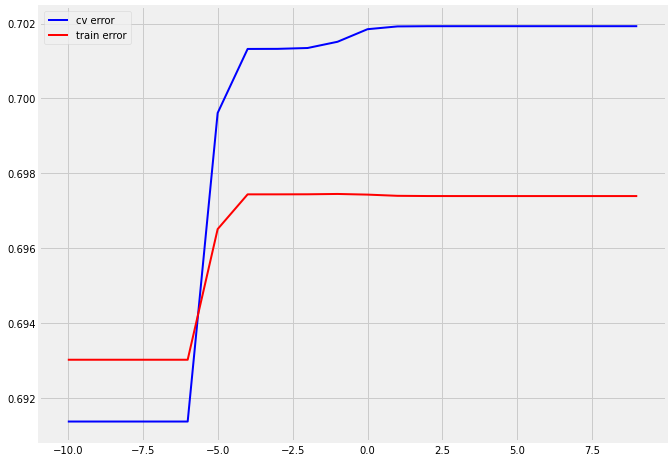

In [42]:
alpha = [10**x for x in np.arange(-10,10,dtype=float)]
log_alpha = np.arange(-10,10)

cv_err = []
train_err = []

for a in alpha:
  clf = linear_model.LogisticRegression(C=a,class_weight='balanced',solver='newton-cg')
  clf.fit(X_train,y_train)
  sig_clf = CalibratedClassifierCV(clf)
  sig_clf.fit(X_train,y_train)

  y_pred = sig_clf.predict_proba(X_test)
  cv_err.append(log_loss(y_test,y_pred))

  y_pred = sig_clf.predict_proba(X_train)
  train_err.append(log_loss(y_train,y_pred))
plt.figure(figsize=(10,8))
plt.plot(log_alpha,cv_err,label='cv error',c='b',lw=2)
plt.plot(log_alpha,train_err,label='train error',c='r',lw=2)
plt.legend(loc='top left')
plt.show()

In [43]:
alpha[np.argmin(cv_err)]

1e-06

In [44]:
np.min(cv_err)

0.6913678029647503

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
accuracy_score(y_test,clf.predict(X_test))

0.5079365079365079

In [47]:
clf = linear_model.LogisticRegression(C=alpha[np.argmin(cv_err)],class_weight='balanced',solver='newton-cg')
clf.fit(X_train,y_train)

LogisticRegression(C=1e-06, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
clf.coef_.T

array([[-1.92800625e-06],
       [-1.52719132e-06],
       [ 3.66247955e-07],
       [ 3.21017255e-07],
       [-1.17490336e-07],
       [-8.90207411e-07]])

In [49]:
cols = np.array(['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']).reshape(-1,1)

In [50]:
feature_imp = pd.DataFrame(np.hstack((cols,clf.coef_.T)),columns=['feature','importance'])

In [51]:
feature_imp['importance'] = pd.to_numeric(feature_imp.importance)

In [52]:
feature_imp.sort_values(by='importance',ascending=True)

,feature,importance
0,Lag1,-1.928006e-06
1,Lag2,-1.527191e-06
5,Volume,-8.902074e-07
4,Lag5,-1.174903e-07
3,Lag4,3.210173e-07
2,Lag3,3.662480e-07


The Top 3 are the most important features of the given data.

##### **Corrected Model**

In [53]:
X_train = train_data[['Lag1','Lag2']]
X_test = test_data[['Lag1','Lag2']]

In [54]:
X_train = X_train.values.reshape(-1,2)
X_test = X_test.values.reshape(-1,2)

In [55]:
model = linear_model.LogisticRegression(solver='newton-cg').fit(X_train,y_train)

In [56]:
y_pred_prob = model.predict_proba(X_test)

In [57]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_prob[:,1]>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,35,76
Up,35,106


#### **Summary**

Both the Statsmodels and the Sklearn give the same values as output with same accuracy for the current dataset.

### **Linear Discriminant Analysis**

In [58]:
model = LinearDiscriminantAnalysis(solver='svd')

In [59]:
model.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [60]:
y_pred_prob = model.predict_proba(X_test)

In [61]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_prob[:,1]>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,35,76
Up,35,106


In [62]:
model.coef_

array([[-0.05544078, -0.0443452 ]])

In [63]:
accuracy_score(y_test,model.predict(X_test))

0.5595238095238095

**Observation:**
- The Linear Disriminant Analysis model does not provide a different solution. We get almost the same results as the Logistic Regression Model.
- The Accuracy of both LDA and Logistic Regression is at approx.$56\%$

### **Quadratic Discriminant Model**

In [64]:
model = QuadraticDiscriminantAnalysis().fit(X_train,y_train)

In [65]:
y_pred_prob = model.predict_proba(X_test)

In [66]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_prob[:,1]>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,30,81
Up,20,121


In [67]:
accuracy_score(y_test,model.predict(X_test))

0.5992063492063492

- The Accuracy for the Quadratic Discriminant Model is approx.$60\%$.
- By far QDA has the best accuracy model.

### **K-Nearest Neighbors**

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
model = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

In [70]:
y_pred_prob = model.predict_proba(X_test)

In [71]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_prob[:,1]>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,43,68
Up,58,83


**Observation:**
- The `n_neighbors=1` was not sufficient to produce better results.

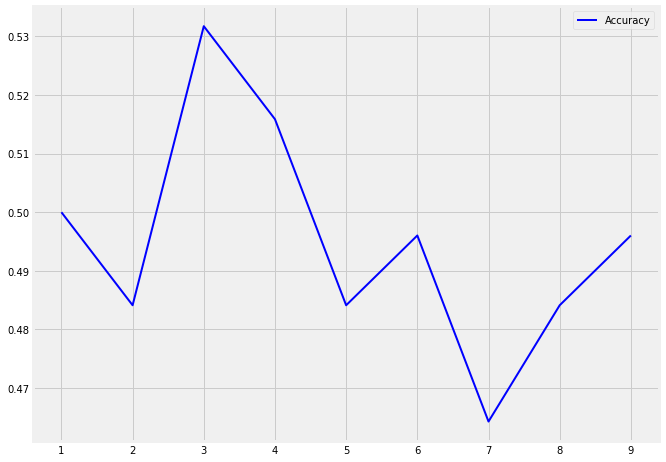

In [72]:
neighbours = np.arange(1,10)
accuracy = []

for i in neighbours:
  model = KNeighborsClassifier(n_neighbors=i).fit(X_train,y_train)
  accuracy.append(accuracy_score(y_test,model.predict(X_test)))

plt.figure(figsize=(10,8))
plt.plot(neighbours,accuracy,label='Accuracy',c='b',lw=2)
plt.legend(loc='best')
plt.show()

**Observation:**
- Even when the `n_neighbours=3` the accuracy is only around $54\%$ 

In [73]:
model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

In [74]:
y_pred_prob = model.predict_proba(X_test)

In [75]:
conf_mat = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_prob[:,1]>0.5})
conf_mat.replace(to_replace={1:'Up',0:'Down','True':'Up','False':'Down'},inplace=True)
conf_mat = conf_mat.groupby(['Actual','Predicted']).size().unstack('Predicted')
conf_mat

Predicted,Down,Up
Actual,,
Down,48,63
Up,55,86


In [76]:
accuracy_score(y_test,model.predict(X_test))

0.5317460317460317

**Observation:**
- KNN doesnt provide a better model compared to the QDA.

## **Caravan Insurance Data**

In [ ]:
data = pd.read_csv()